# Setup

In [292]:
# Get project folder
!git clone https://github.com/Survedog/MLTermProject.git project

fatal: destination path 'project' already exists and is not an empty directory.


In [293]:
import pandas as pd
import numpy as np
pd.options.display.max_columns=100


# Load Data

In [294]:
answer_correct_data = pd.read_csv('project/data/train_data/train_task_3_4.csv', na_values='?')
answer_metadata = pd.read_csv('project/data/metadata/answer_metadata_task_3_4.csv', na_values='?')
question_metadata = pd.read_csv('project/data/metadata/question_metadata_task_3_4.csv', na_values='?')
student_metadata = pd.read_csv('project/data/metadata/student_metadata_task_3_4.csv', na_values='?')
subject_metadata = pd.read_csv('project/data/metadata/subject_metadata.csv', na_values='?')

In [295]:
answer_correct_data.head()

,QuestionId,UserId,AnswerId,IsCorrect,CorrectAnswer,AnswerValue
0,898,2111,280203,1,2,2
1,767,3062,55638,1,3,3
2,165,1156,386475,1,2,2
3,490,1653,997498,1,4,4
4,298,3912,578636,1,3,3


In [296]:
answer_metadata.head()

,AnswerId,DateAnswered,Confidence,GroupId,QuizId,SchemeOfWorkId
0,1451945,2019-10-30 14:34:00.000,NaN,4,32,52562.0
1,45325,2020-01-06 18:53:00.000,75.0,185,66,52562.0
2,687013,2020-01-18 10:52:00.000,NaN,235,64,52562.0
3,91254,2020-02-29 17:25:00.000,NaN,194,97,52562.0
4,1225855,2020-03-06 15:07:00.000,NaN,95,115,52562.0


In [297]:
question_metadata.head()

,QuestionId,SubjectId
0,684,"[3, 71, 98, 209]"
1,87,"[3, 71, 98, 209]"
2,679,"[3, 71, 98, 209]"
3,685,"[3, 71, 98, 209]"
4,222,"[3, 71, 98, 209]"


In [298]:
student_metadata.head()

,UserId,Gender,DateOfBirth,PremiumPupil
0,3837,2,2007-10-01 00:00:00.000,0.0
1,207,0,NaN,NaN
2,3581,2,2008-03-01 00:00:00.000,0.0
3,6028,2,2008-01-01 00:00:00.000,0.0
4,1451,0,NaN,NaN


In [299]:
subject_metadata.head()

,SubjectId,Name,ParentId,Level
0,3,Maths,NaN,0
1,32,Number,3.0,1
2,33,BIDMAS,144.0,3
3,34,Upper and Lower Bounds,141.0,3
4,35,Calculator Use,32.0,2


# Calculate students' feature values for clustering them

In [300]:
# Intergrate and group answer information for each students(users).
answer_integrated = pd.merge(answer_correct_data, answer_metadata, 'inner', 'AnswerId')
answer_integrated_user_group = answer_integrated.groupby('UserId')

In [301]:
# Calculate mean correct rate, mean confidence and the amount of solved questions for each student.
student_solve_info = pd.DataFrame(columns=['SolvedCount', 'CorrectRate', 'MeanConfidence'])
student_solve_info[['CorrectRate', 'MeanConfidence']] = answer_integrated_user_group.mean()[['IsCorrect', 'Confidence']]
student_solve_info['SolvedCount'] = answer_integrated_user_group.size()

<ipython-input-301-eda47f2e1434>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  student_solve_info[['CorrectRate', 'MeanConfidence']] = answer_integrated_user_group.mean()[['IsCorrect', 'Confidence']]


In [302]:
# Put UserId as dataframe's column. (Userid was the index of the dataframe)
student_solve_info.reset_index(inplace=True)

In [303]:
# Exclude the students who solved less than 50 questions.
student_solve_info = student_solve_info[student_solve_info['SolvedCount'] >= 50]

In [304]:
# Exclude rows with NaN value.
student_solve_info.isnull().sum() # 634 rows with NaN
student_solve_info.dropna(axis='index', inplace=True)

In [305]:
# Perform feature scaling for students' features before clustering.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
student_solve_info_scaled = scaler.fit_transform(student_solve_info, y=None)
student_solve_info_scaled = pd.DataFrame(student_solve_info_scaled, index=student_solve_info.index, columns=student_solve_info.columns)
student_solve_info_scaled[['UserId', 'SolvedCount']] = student_solve_info[['UserId', 'SolvedCount']] # restore UserId and SolvedCount column values.
student_solve_info_scaled.describe()

,UserId,SolvedCount,CorrectRate,MeanConfidence
count,4284.000000,4284.000000,4284.000000,4284.000000
mean,3041.310924,298.353408,0.439819,0.691973
std,1780.296043,182.108883,0.215910,0.219878
min,1.000000,50.000000,0.000000,0.000000
25%,1501.500000,144.000000,0.270150,0.562228
50%,3004.500000,259.000000,0.430894,0.729919
75%,4591.250000,443.250000,0.590602,0.858696
max,6147.000000,827.000000,1.000000,1.000000


#Using Clustering, Divide students by their academic achievement level

In [306]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=1)
student_solve_info_scaled['AchievementGroup'] = kmeans.fit_predict(student_solve_info_scaled.drop(columns=['UserId', 'SolvedCount'], inplace=False))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [307]:
# Check which acheivement group has higher academic achievement level
print(kmeans.cluster_centers_, '\n')
print('[Group 0\'s mean values]\n', student_solve_info_scaled[student_solve_info_scaled['AchievementGroup'] == 0][['CorrectRate', 'MeanConfidence']].mean(), '\n')
print('[Group 1\'s mean values]\n', student_solve_info_scaled[student_solve_info_scaled['AchievementGroup'] == 1][['CorrectRate', 'MeanConfidence']].mean(), '\n')

[[0.58499053 0.83235406]
 [0.29010369 0.54719898]] 

[Group 0's mean values]
 CorrectRate       0.585214
MeanConfidence    0.831452
dtype: float64 

[Group 1's mean values]
 CorrectRate       0.289172
MeanConfidence    0.547456
dtype: float64 



Achievement group 0 has higher value in both CorrectRate and MeanConfidence.
Thus, We can say that achievement group 0 is the upper academic achievement group, and group 1 is the lower academic achievement group.

# Compute mean confidence of each question seperately for two achievement groups

In [308]:
# Integrate the achievement group information to the answer data
answer_integrated = pd.merge(answer_integrated, student_solve_info_scaled[['UserId', 'AchievementGroup']], 'left', 'UserId')
answer_integrated['AchievementGroup'].value_counts()

1.0    639208
0.0    638938
Name: AchievementGroup, dtype: int64

In [309]:
# Make two confidence columns for each achievement group
answer_integrated[['UpperGroupConfidence', 'LowerGroupConfidence']] = np.NaN
answer_integrated['UpperGroupConfidence'] = answer_integrated[answer_integrated['AchievementGroup'] == 0]['Confidence']
answer_integrated['LowerGroupConfidence'] = answer_integrated[answer_integrated['AchievementGroup'] == 1]['Confidence']
answer_integrated.describe()

,QuestionId,UserId,AnswerId,IsCorrect,CorrectAnswer,AnswerValue,Confidence,GroupId,QuizId,SchemeOfWorkId,AchievementGroup,UpperGroupConfidence,LowerGroupConfidence
count,1.382727e+06,1.382727e+06,1.382727e+06,1.382727e+06,1.382727e+06,1.382727e+06,346428.000000,1.382727e+06,1.382727e+06,1.267192e+06,1.278146e+06,223621.000000,122807.000000
mean,4.682276e+02,3.036283e+03,7.544279e+05,5.373317e-01,2.390497e+00,2.437992e+00,73.947617,1.961880e+02,6.139972e+01,5.256224e+04,5.001056e-01,83.145925,57.198287
std,2.735797e+02,1.770599e+03,4.356190e+05,4.986046e-01,1.066479e+00,1.067624e+00,31.216004,1.146402e+02,3.125018e+01,5.732887e+01,5.000002e-01,24.759724,34.610828
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000,0.000000e+00,0.000000e+00,5.256200e+04,0.000000e+00,0.000000,0.000000
25%,2.330000e+02,1.515000e+03,3.772935e+05,0.000000e+00,1.000000e+00,2.000000e+00,50.000000,9.500000e+01,3.700000e+01,5.256200e+04,0.000000e+00,75.000000,25.000000
50%,4.680000e+02,3.009000e+03,7.544530e+05,1.000000e+00,2.000000e+00,2.000000e+00,75.000000,1.980000e+02,6.300000e+01,5.256200e+04,1.000000e+00,100.000000,50.000000
75%,7.030000e+02,4.565000e+03,1.131772e+06,1.000000e+00,3.000000e+00,3.000000e+00,100.000000,3.000000e+02,8.600000e+01,5.256200e+04,1.000000e+00,100.000000,75.000000
max,9.470000e+02,6.147000e+03,1.508916e+06,1.000000e+00,4.000000e+00,4.000000e+00,100.000000,3.890000e+02,1.190000e+02,6.632100e+04,1.000000e+00,100.000000,100.000000


# Calculate feature values to measure question quality, and make up train data

In [310]:
# Group the answer data by QuestionId
answer_integrated_question_group = answer_integrated.groupby('QuestionId')

In [311]:
# Calculate for feature values for each question
train_data = pd.DataFrame(columns=['IncorrectRate', 'AnswerVariance', 'UpperGroupConfidence', 'LowerGroupConfidence'])
train_data.index.name = 'QuestionId'
train_data['AnswerVariance'] = answer_integrated_question_group.var()['AnswerValue']
train_data['IncorrectRate'] = 1 - answer_integrated_question_group.mean()['IsCorrect']
train_data[['UpperGroupConfidence', 'LowerGroupConfidence']] = answer_integrated_question_group.mean()[['UpperGroupConfidence', 'LowerGroupConfidence']]

<ipython-input-311-49ee1b2f8fa6>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_data['AnswerVariance'] = answer_integrated_question_group.var()['AnswerValue']
<ipython-input-311-49ee1b2f8fa6>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_data['IncorrectRate'] = 1 - answer_integrated_question_group.mean()['IsCorrect']
<ipython-input-311-49ee1b2f8fa6>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  trai

In [312]:
# Replace NaN confidence values
print(train_data.isnull().sum())
print(answer_integrated[answer_integrated['QuestionId']==1].info())

# There is some questions that none of its answers have either of the confidence info.
# -> Fill them up with mean confidence values of each group.
train_data['LowerGroupConfidence'] = train_data['LowerGroupConfidence'].fillna(train_data['LowerGroupConfidence'].mean())
train_data['UpperGroupConfidence'] = train_data['UpperGroupConfidence'].fillna(train_data['UpperGroupConfidence'].mean())
train_data.isnull().sum()

IncorrectRate            0
AnswerVariance           0
UpperGroupConfidence    45
LowerGroupConfidence    58
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 6452 to 1291796
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   QuestionId            14 non-null     int64  
 1   UserId                14 non-null     int64  
 2   AnswerId              14 non-null     int64  
 3   IsCorrect             14 non-null     int64  
 4   CorrectAnswer         14 non-null     int64  
 5   AnswerValue           14 non-null     int64  
 6   DateAnswered          14 non-null     object 
 7   Confidence            0 non-null      float64
 8   GroupId               14 non-null     int64  
 9   QuizId                14 non-null     int64  
 10  SchemeOfWorkId        1 non-null      float64
 11  AchievementGroup      1 non-null      float64
 12  UpperGroupConfidence  0 non-null      float64
 13

IncorrectRate           0
AnswerVariance          0
UpperGroupConfidence    0
LowerGroupConfidence    0
dtype: int64

# Reduce the feature dimension using PCA

In [313]:
# Scale the feature values before PCA
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
train_data_scaled = pd.DataFrame(train_data_scaled, index=train_data.index, columns=train_data.columns)
train_data_scaled.describe()

,IncorrectRate,AnswerVariance,UpperGroupConfidence,LowerGroupConfidence
count,948.000000,948.000000,948.000000,948.000000
mean,0.575116,0.315115,0.622323,0.546315
std,0.182853,0.110457,0.176214,0.141749
min,0.000000,0.000000,0.000000,0.000000
25%,0.446176,0.246850,0.520160,0.462588
50%,0.588857,0.315836,0.641803,0.546315
75%,0.715362,0.381184,0.754300,0.642857
max,1.000000,1.000000,1.000000,1.000000


In [314]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
train_data_PCA = pca.fit_transform(train_data_scaled)
train_data_PCA = pd.DataFrame(data=train_data_PCA, columns=['PC1', 'PC2', 'PC3'])

# Define functions for validation

In [315]:
# Function for calculating prediction score for each expert's decision
def calcPredictionScore(question_compare_data, question_quality_rank):
    question_quality_compare = []
    for index in question_compare_data.index:
        left_question = question_compare_data.at[index, 'left']
        right_question = question_compare_data.at[index, 'right']
        question_quality_compare.append(1 if question_quality_rank[left_question] < question_quality_rank[right_question] else 2)

    prediction_scores = pd.Series([0.0, 0.0, 0.0, 0.0, 0.0])
    for index in question_compare_data.index:
        if question_quality_compare[index] == question_compare_data['T1_ALR'][index]:
            prediction_scores[0] += 1
        if question_quality_compare[index] == question_compare_data['T2_CL'][index]:
            prediction_scores[1] += 1
        if question_quality_compare[index] == question_compare_data['T3_GF'][index]:
            prediction_scores[2] += 1
        if question_quality_compare[index] == question_compare_data['T4_MQ'][index]:
            prediction_scores[3] += 1
        if question_quality_compare[index] == question_compare_data['T5_NS'][index]:
            prediction_scores[4] += 1

    for expert in range(5):
        prediction_scores[expert] = prediction_scores[expert] / len(question_compare_data)
    return prediction_scores

In [316]:
import matplotlib.pyplot as plt

# Function for finding the quality measure predcition that results in the best validation score
def calcBestQuestionQualityPrediction(feature_data, question_compare_data, pc1_coef_list, pc2_coef_list, pc3_coef_list):
    best_score = 0.0
    best_question_quality = pd.DataFrame(columns=['QualityMeasure', 'Rank'])
    best_coef_map = {"pc1" : 0.0, "pc2" : 0.0, "pc3" : 0.0}

    for pc1_coef in pc1_coef_list:
        for pc2_coef in pc2_coef_list:
            for pc3_coef in pc3_coef_list:

                question_quality = pd.DataFrame(columns=['QualityMeasure', 'Rank'])
                question_quality.index.name = 'QuestionId'

                # Calculate the quality measure value (i.e. the weighted sum of the features)
                feature_data['PC1_weighted'] = feature_data['PC1'].apply(lambda value: pc1_coef*value)
                feature_data['PC2_weighted'] = feature_data['PC2'].apply(lambda value: pc2_coef*value)
                feature_data['PC3_weighted'] = feature_data['PC3'].apply(lambda value: pc3_coef*value)
                question_quality['QualityMeasure'] = feature_data[['PC1_weighted', 'PC2_weighted', 'PC3_weighted']].apply(np.sum, axis='columns')

                # Assign quality rank to each question based on the quality measure value
                question_quality['Rank'] = question_quality['QualityMeasure'].rank(method='first', ascending=False)
                question_quality.describe()

                # Calculate prediction scores for the experts' decision
                validation_scores = calcPredictionScore(question_compare_data, question_quality['Rank'])
                mean_score = validation_scores.mean()

                if mean_score > best_score:
                    best_score = mean_score
                    best_question_quality = question_quality
                    best_coef_map['pc1'] = pc1_coef
                    best_coef_map['pc2'] = pc2_coef
                    best_coef_map['pc3'] = pc3_coef

                #  Plot the mean score with current coefficient values
                plt.figure(1)
                plt.scatter(pc1_coef, mean_score)
                plt.figure(2)
                plt.scatter(pc2_coef, mean_score)
                plt.figure(3)
                plt.scatter(pc3_coef, mean_score)

    print("Max Validation Mean Score: ", best_score)
    print("Best Coefficient: ", best_coef_map)
    return best_question_quality.astype(dtype={'QualityMeasure':'float64', 'Rank':'int64'})

# Validation (Training process)

In [317]:
# Load validation data and submission template
validation_data = pd.read_csv('project/data/test_data/quality_response_remapped_public.csv', na_values='?')
template = pd.read_csv('project/submission/template.csv', na_values='?')

Max Validation Mean Score:  0.768
Best Coefficient:  {'pc1': 0.1, 'pc2': 0.0, 'pc3': 0.2}


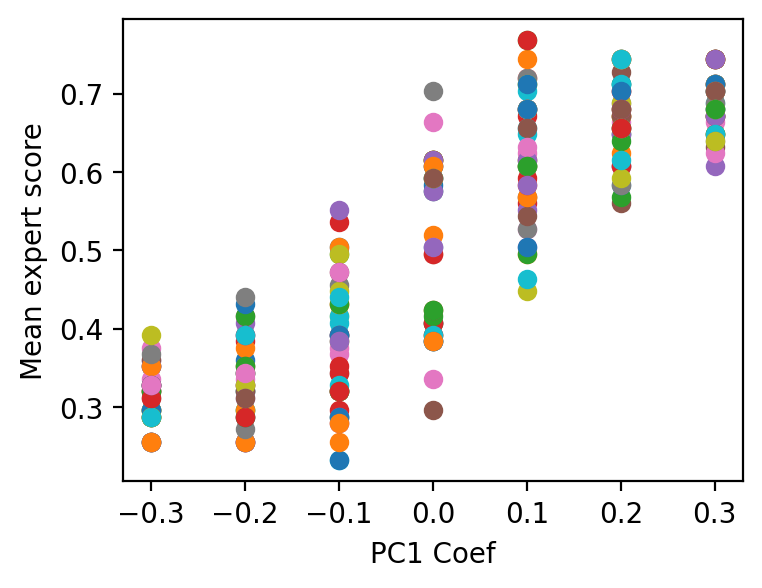

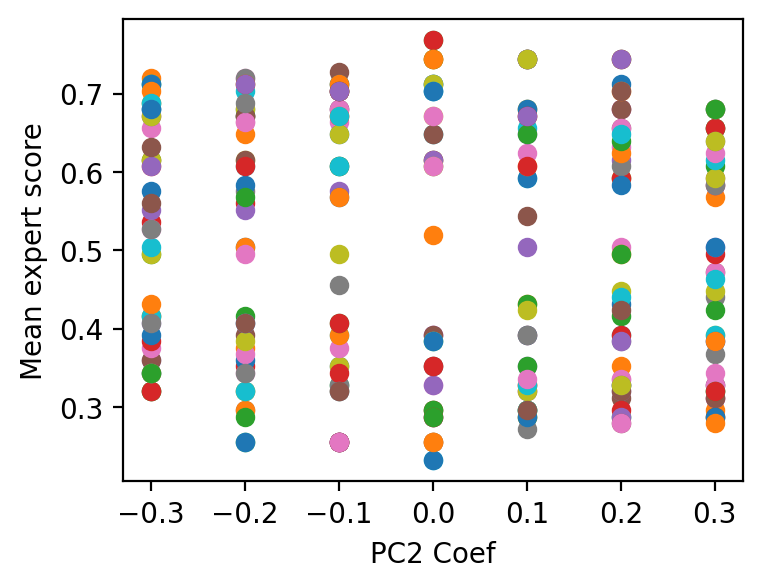

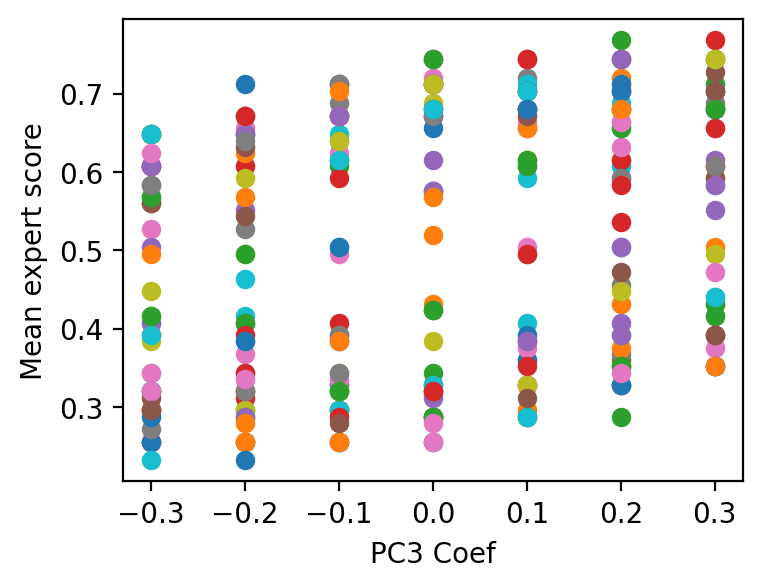

In [318]:
# For plotting
fig1 = plt.figure(1, figsize=(4,3), dpi = 200)
plt.xlabel('PC1 Coef')
plt.ylabel('Mean expert score')

fig2 = plt.figure(2, figsize=(4,3), dpi = 200)
plt.xlabel('PC2 Coef')
plt.ylabel('Mean expert score')

fig2 = plt.figure(3, figsize=(4,3), dpi = 200)
plt.xlabel('PC3 Coef')
plt.ylabel('Mean expert score')

# Predict the question quality value and rank using validation with gridsearch
question_quality_list = calcBestQuestionQualityPrediction(train_data_PCA, validation_data,
                                                          [-0.30, -0.20, -0.10, 0.0, 0.10, 0.20, 0.30], # Coef for PC1
                                                          [-0.30, -0.20, -0.10, 0.0, 0.10, 0.20, 0.30], # Coef for PC2
                                                          [-0.30, -0.20, -0.10, 0.0, 0.10, 0.20, 0.30]) # Coef for PC3

In [319]:
# Write question ranks to csv file
for question_id in template['QuestionId']:
    template.at[question_id, 'ranking'] = question_quality_list.at[question_id, 'Rank']

template.to_csv('project/submission/20182632.csv', index=False)

# Get final test score

In [320]:
# Load test data
test_data = pd.read_csv('project/data/test_data/quality_response_remapped_private.csv', na_values='?')

In [321]:
# Compute prediction score for the test data
test_scores = calcPredictionScore(test_data, question_quality_list['Rank'])

In [322]:
# Show test score
print('[Test Scores]\n', test_scores)
print("Max Test Score: ", test_scores.max())

[Test Scores]
 0    0.84
1    0.64
2    0.72
3    0.64
4    0.68
dtype: float64
Max Test Score:  0.84


# Further analysis

In [323]:
# Explained variance ratio of each principal components
print('Explained variance ratio:', pca.explained_variance_ratio_)

Explained variance ratio: [0.67348452 0.16552447 0.09122639]


In [324]:
# Principal component direction of each original features
components_dataframe = pd.DataFrame(pca.components_, columns=train_data_scaled.columns, index = ['PC1', 'PC2', 'PC3'])
print(components_dataframe)

     IncorrectRate  AnswerVariance  UpperGroupConfidence  LowerGroupConfidence
PC1       0.632235        0.253943             -0.587810             -0.436202
PC2      -0.596995       -0.425693             -0.621823             -0.275169
PC3      -0.110571       -0.028073              0.504185             -0.856028
